## Setup

In [1]:
#%matplotlib widget;
#%matplotlib inline;
#pygui(true);

In [2]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

  Activating project at `C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT`

Num threads: 6

2023-05-13T18:07:27.756

In [3]:
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Bases.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")
@everywhere include(dir * "/functions/SingleVertexApproxns.jl")

@everywhere include(dir * "/functions/simulationFunctions/GroundStates.jl")

## GLOBAL INPUTS

### Energy Scales

In [4]:
# Hamiltonian constants
@everywhere global const λ::Float64 = 1
@everywhere global const ξ::Float64 = 0

# which dynamics to use (only affects microcanonical functions)
@everywhere global const twoFlip::Bool = true

# demon quantisation
@assert (λ==1 && ξ==0) || (λ==0 && ξ==1) # otherwise demons will break b/c not quantised
@everywhere global isSpinIce = (λ==0 && ξ==1)
@everywhere global const δE::Int = (λ==0) ? 8*ξ : 4*λ

### Lattice

In [5]:
# chosen basis
@everywhere Basis = HexBasis() # CubicBasis(2) # HexBasis() # DiamondBasis()

# coordination number of lattice (ASSERTED CONSTANT FOR OUR PURPOSES)
@everywhere z = Coordination(Basis)

# function to generate groundstate
@everywhere isDiamond = (z==4 && length(Basis[4])==3) # certainly not general, but avoids human error in me setting the ground state explicitly...
@everywhere GroundState!(vertices, edges) = GroundState!(vertices, edges, isDiamond)

In [6]:
# Approxn of self-diffusion coeff at zero density

@everywhere q = (mod(z,2)==0) ? 2 : 3 # minimal excitation charge |Q|
@everywhere na = (q + z) / 2 # number of allowed directions which don't increase |Q| on site

@everywhere global Dself = ((!isSpinIce || na==z) ? z : na*(1-2/na^2)) / 2 / length(Basis[4])

### Approxns

In [7]:
if twoFlip
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z)) .* (1 .- Magnetisation(T, h, z)) ./ 2 # additional magnetisation factor for +-+- bond percolation
else
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z))
end

Cfun = (T, h) -> 2/z .* (λ^2 .* sech.(λ ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ T.^2

if twoFlip
    Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
else
    Dfun = (T, h) -> Kfun(T, h) ./ HeatCapacity(T, h, z)
end

#67 (generic function with 1 method)

### Testing Data Structure

In [19]:
TestBasis = HexBasis()
vertices, edges = LatticeGrid([4, 6], [false, false], TestBasis)

GroundState!(vertices, edges, false)

Lvertices, Ledges = LineGraph(vertices, edges);

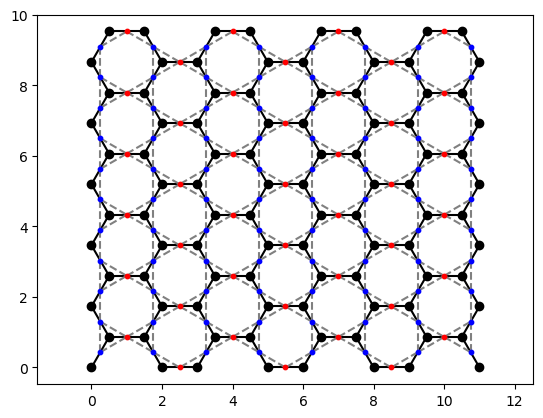

In [20]:
f = figure()
for e in edges
    r1 = vertices[e.∂[1]].x
    r2 = vertices[e.∂[2]].x
    
    if length(TestBasis[4]) == 2
        plot([r1[1]; r2[1]], [r1[2]; r2[2]], color=:black, zorder=1)
    else
        plot3D([r1[1]; r2[1]], [r1[2]; r2[2]], [r1[3]; r2[3]], color=(e.σ ? :red : :blue), zorder=1) 
    end
end

for v in vertices
    if length(TestBasis[4]) == 2
        scatter(v.x[1], v.x[2], color=:black, zorder=3)
    else
        scatter3D(v.x[1], v.x[2], v.x[3], color=:black, zorder=2)
    end
end

for e in Ledges
    r1 = Lvertices[e.∂[1]].x
    r2 = Lvertices[e.∂[2]].x
    
    if length(TestBasis[4]) == 2
        plot([r1[1]; r2[1]], [r1[2]; r2[2]], color=:gray, zorder=2, "--") 
    else
        plot3D([r1[1]; r2[1]], [r1[2]; r2[2]], [r1[3]; r2[3]], color=:gray, zorder=1, "--") 
    end
    #
end

for v in Lvertices
    if length(TestBasis[4]) == 2
        scatter(v.x[1], v.x[2], color=(v.σ ? :red : :blue), s=10, zorder=4) # color=(A(edges,v)<0 ? :yellow : :black)  
    else
        scatter3D(v.x[1], v.x[2], v.x[3], color=(v.σ ? :red : :blue), s=10, zorder=2) # color=(A(edges,v)<0 ? :yellow : :black)  
    end
end

axis("equal")
savefig("figs/lattice.pdf")

## Thermal Conductivity

## Thermal Bath Method


In [ ]:
@everywhere include(dir * "/functions/simulationFunctions/DemonHeatBath.jl")

In [ ]:
L = [6, 6]
PBC = [false, true]

𝒽 = [0.0]

num_histories = 1
therm_runtime = 100
runtime = 200
t_therm = 100
t_autocorr = 1
N_blocks = -1

W = 5
Tc = 0.1
Th = 10.0

T, κ, C, Diff, TStd, κStd, CStd, DiffStd = BathSimulation(L, PBC, Basis, W, Tc, Th, num_histories, therm_runtime, runtime, t_therm, t_autocorr, N_blocks, 𝒽);

idx = W+1:size(T, 2)-W+1;

In [ ]:
# FUDGE FACTOR - WHYYY MISSING FACTOR 1/2????
κ[1,:,:] ./= 2;
κ[2,:,:] ./= 2;

In [ ]:
colors = jetmap(length(𝒽))

In [ ]:
figure()
for i in eachindex(𝒽)
    plotWithError(T[1,:,i], 1:size(T, 2), colors[i], "+", TStd[1,:,i])
    plotWithError(T[2,:,i], 1:size(T, 2), colors[i], "x", TStd[2,:,i])
end
savefig("figs/Demon_Bath_Temperatures.png")

In [ ]:
figure()
for i in eachindex(𝒽)
    #plot(T[1,idx,i], Cfun(T[1,idx,i], 𝒽[i]), color=colors[i])
    #plot(T[1,idx,i], HeatCapacity(T[1,idx,i], 𝒽[i], z), color=colors[i], "--")
    
    plotWithError(C[1,idx,i], T[1,idx,i], colors[i], "+")#, CStd[1,idx,i], TStd[1,idx,i])
    plotWithError(C[2,idx,i], T[2,idx,i], colors[i], "x")#, CStd[2,idx,i], TStd[2,idx,i])
end
ylim([0, 2])
savefig("figs/Demon_Bath_Capacity.png")

In [ ]:
figure()
for i in eachindex(𝒽)
    plot(T[1,idx,i], Kfun(T[1,idx,i], 𝒽[i]), color=colors[i])
    
    plotWithError(κ[1,idx,i], T[1,idx,i], colors[i], "+")#, κStd[1,idx,i], TStd[1,idx,i])
    plotWithError(κ[2,idx,i], T[2,idx,i], colors[i], "x")#, κStd[2,idx,i], TStd[2,idx,i])
end

savefig("figs/Demon_Bath_Conductivity.png")

In [ ]:
figure()
for i in eachindex(𝒽)
    plot(T[1,idx,i], Dfun(T[1,idx,i], 𝒽[i]), color=colors[i])
    plotWithError(Diff[1,idx,i], T[1,idx,i], colors[i], "+")#, DiffStd[1,idx,i], TStd[1,idx,i])
    
    plot(T[2,idx,i], Dfun(T[2,idx,i], 𝒽[i]), color=colors[i], "--")
    plotWithError(Diff[2,idx,i], T[2,idx,i], colors[i], "x")#, DiffStd[2,idx,i], TStd[2,idx,i])
end
savefig("figs/Demon_Bath_Diffusivity.png")

In [ ]:
save("data/DemonBath.jld", "Size", L, 
                           "Fields", 𝒽, 
                           "num_histories", num_histories, 
                           "therm_runtime", therm_runtime, 
                           "runtime", runtime, 
                           "t_therm", t_therm, 
                           "basis", Basis, 
                           "lambda", λ, 
                           "xi", ξ, 
                           "EnergyQuantisation", δE, 
                           "Dself", Dself, 
                           "twoFlip", twoFlip, 
                           "idx", idx, 
                           "Temperature", T, 
                           "TemperatureStd", TStd, 
                           "Conductivity", κ, 
                           "ConductivityStd", κStd, 
                           "Capacity", C, 
                           "CapacityStd", CStd, 
                           "Diffusivity", Diff, 
                           "DiffusivityStd", DiffStd)

In [ ]:
T       = Nothing
κ       = Nothing
C       = Nothing
Diff    = Nothing
TStd    = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

In [ ]:
t1 = now()
print("\n", canonicalize(t1 - t0))

## Green-Kubo Method

### Demon Dynamics

In [ ]:
@everywhere include(dir * "/functions/simulationFunctions/DemonKubo.jl")

In [ ]:
#global testing = []

# PARAMETERS
L = [5, 5]
PBC = [true, true]

# find minimal representable temperature (just done for 𝒽=0 for now - MAYBE MODIFY TO PICK MAX OVER DIFF FIELDS??
#Nmin = (T,h) -> (λ == 0 ? 2/(4*exp(-4/T)/3+h*exp(-2*h/T)) : 2/(exp(-2/T)+2*h*exp(-2*h/T))) # minimal lattice size on which T=Tmin is possible - see https://www.desmos.com/calculator/ll1ljvjmcg for details
Tmin = 0.1 # find_zero((T) -> prod(L)-Nmin(T,0), 0.3)
Tmax = 10.0
NumT = 50
T = collect(range(Tmin, Tmax, length=NumT)) # the +0.1 is a fudge factor to fix our approximations earlier... (exact value doesn't matter b/c just adds ~a single demon)

𝒽 = [0.0] # range(0, 2, length=9)

num_histories = 1
runtime = 1500
t_therm = 500
t_cutoff = 100
t_autocorr = 100
N_blocks = -1

# EVALUATION
Tobs, κ, C, Diff, TobsStd, κStd, CStd, DiffStd = DKuboSimulation(L, PBC, Basis, num_histories, runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽);

In [ ]:
now()

In [ ]:
colors = jetmap(length(𝒽))

In [ ]:
figure()
for i in eachindex(𝒽)
    plotWithError(Tobs[:,i], T, colors[i], ".", "" , TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Temperature.png")
# Just to check that out temperature estimates aren't too far off

In [ ]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Kfun(T[2:end], 𝒽[i]), color=colors[i])
    plotWithError(κ[:,i], Tobs[:,i], colors[i], ".", "" , κStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Conductivity.png")

In [ ]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Cfun(T[2:end], 𝒽[i]), color=colors[i])
    
    plotWithError(C[:,i], Tobs[:,i], colors[i], ".", "" , CStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Capacity.png")

In [ ]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Dfun(T[2:end], 𝒽[i]), color=colors[i])
    
    plotWithError(Diff[:,i], Tobs[:,i], colors[i], ".", "" , DiffStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Diff.png")

In [ ]:
save("data/DemonKubo.jld", "Size", L, 
                           "Fields", 𝒽, 
                           "num_histories", num_histories, 
                           "therm_runtime", therm_runtime, 
                           "runtime", runtime, 
                           "t_therm", t_therm, 
                           "t_cutoff", t_cutoff, 
                           "basis", Basis,
                           "lambda", λ, 
                           "xi", ξ, 
                           "EnergyQuantisation", δE,
                           "Dself", Dself, 
                           "twoFlip", twoFlip, 
                           "TargetTemperature", T, 
                           "ObservedTemperature", Tobs, 
                           "ObservedTemperatureStd", TobsStd, 
                           "Conductivity", κ, 
                           "ConductivityStd", κStd, 
                           "Capacity", C, 
                           "CapacityStd", CStd, 
                           "Diffusivity", Diff, 
                           "DiffusivityStd", DiffStd)

In [ ]:
Tobs    = Nothing
κ       = Nothing
C       = Nothing
Diff    = Nothing
TobsStd = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

In [ ]:
t2 = now()
print(canonicalize(t2 - t1))

### Microcanonical Dynamics

In [18]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [19]:
# PARAMETERS
L = [32, 32]
PBC = [true, true]

Tmin = 0.01
Tmax = 10.0
NumT = 50

#Tmax *= (λ == 0 ? 1.0 : 0.5)
T = collect(range(Tmin, Tmax, length=NumT))

𝒽 = range(0, 1, length=7)

num_histories = 25
therm_runtime = 15000
runtime = 15000
t_therm = 5000
t_autocorr = 100
N_blocks = -1
t_cutoff = 100

allComponents = false

# EVALUATION
κ, C, Diff, M, ℙ, κStd, CStd, DiffStd, MStd, ℙStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽, allComponents);

In [20]:
now()

2023-05-13T19:51:48.063

In [21]:
colors = jetmap(length(𝒽));

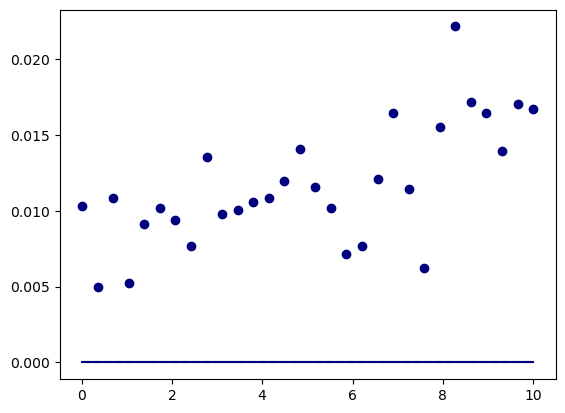

In [22]:
figure()
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M)
function Mfun(T, h)
    m = zeros(length(T))
    
    if h==0
        return m
    end
    
    for i in eachindex(T)
        m[i] = find_zero((M) -> Tfun(M, h) - T[i], (0, 1))
    end
    return m
end

Mfun0 = (T, h) -> tanh.(h ./ T)

for n in eachindex(𝒽)
    plot(T, Magnetisation(T, 𝒽[n], z), color=colors[n])
    plot(T, tanh.(𝒽[n] ./ T), "--", color=colors[n])
    scatter(T, M[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Magnetisation.png")

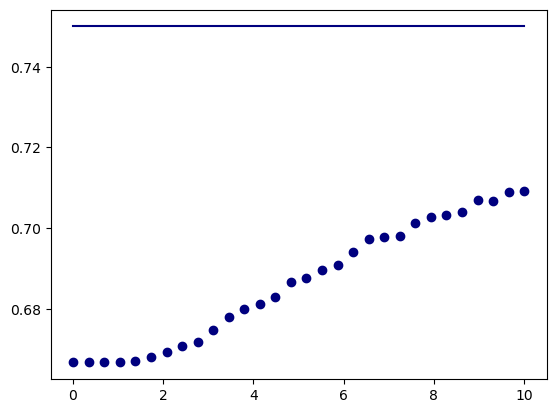

In [23]:
figure()
#ℙfunMF = (T, h) -> 1 .- (1 .- Mfun0(T, h) .^2) ./ 3
ℙfunLim = (T, h) -> 1 .- (1 .- Magnetisation(T, h, z) .^2) ./ 4

for n in eachindex(𝒽)
    plot(T, ℙfunLim(T, 𝒽[n]), color=colors[n])
    scatter(T, ℙ[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Percolation.png")

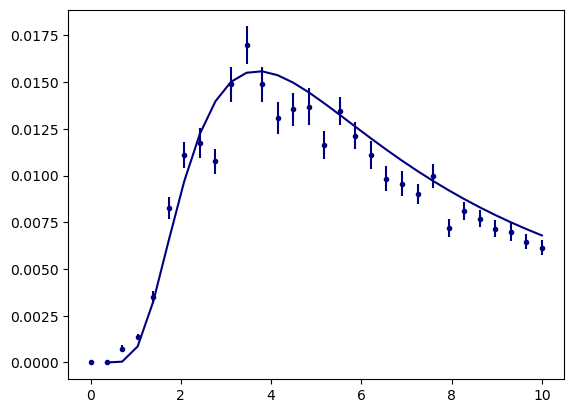

In [24]:
dim = allComponents ? length(L) : 1
for i in 1:dim
    for j in 1:dim
        figure()
        for n in eachindex(𝒽)
            plot(T[2:end], Kfun(T[2:end], 𝒽[n]), color=colors[n])

            plotWithError(κ[i,j,:,n], T, colors[n], ".", "" , κStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Conductivity_" * string(i) * string(j) * ".png")
    end
end

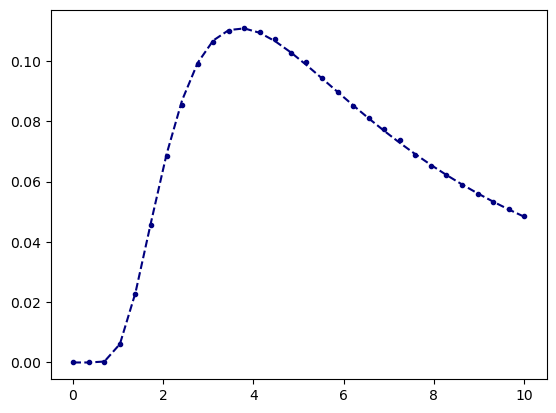

In [25]:
figure()
for n in eachindex(𝒽)
    #plot(T[2:end], Cfun(T[2:end], 𝒽[n]), color=colors[n])
    plot(T, HeatCapacity(T, 𝒽[n], z), "--", color=colors[n])
    
    plotWithError(C[:,n], T, colors[n], ".", "" , CStd[:,n])
end
savefig("figs/Micro_Kubo_Capacity.png")

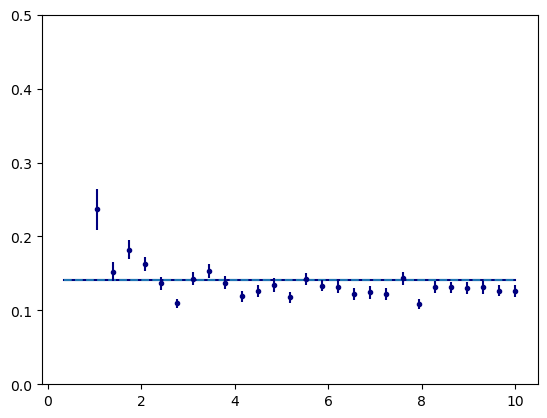

In [30]:
figure()
for i in 1:dim
    for j in 1:dim
        figure()
        for n in eachindex(𝒽)
            plot(T[2:end], Dfun(T[2:end], 𝒽[n]), color=colors[n])
            plot(T[2:end], Kfun(T[2:end], 𝒽[n]) ./ HeatCapacityTest(T[2:end], 𝒽[n], z), "--")

            plotWithError(Diff[i,j,:,n], T, colors[n], ".", "" , DiffStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Diff_" * string(i) * string(j) * ".png")
    end
end

In [ ]:
save("data/MicroKubo.jld", "Size", L,
                           "Fields", 𝒽,
                           "num_histories", num_histories,
                           "therm_runtime", therm_runtime,
                           "runtime", runtime,
                           "t_therm", t_therm,
                           "t_cutoff", t_cutoff,
                           "basis", Basis,
                           "lambda", λ,
                           "xi", ξ,
                           "EnergyQuantisation", δE,
                           "Dself", Dself,
                           "twoFlip", twoFlip,
                           "allComponents", allComponents,
                           "Temperature", T,
                           "Magnetisation", M,
                           "Percolation", ℙ,
                           "Conductivity", κ,
                           "ConductivityStd", κStd,
                           "Capacity", C,
                           "CapacityStd", CStd,
                           "Diffusivity", Diff,
                           "DiffusivityStd", DiffStd)

In [ ]:
κ       = Nothing
C       = Nothing
Diff    = Nothing
M       = Nothing
ℙ       = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing
MStd    = Nothing
ℙStd    = Nothing

In [ ]:
t3 = now()
print("\n", canonicalize(t3 - t2))

### Diffusive Motion

In [ ]:
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")

In [ ]:
L = [32, 32]
PBC = [true, true]

therm_runtime = floor(Int64,(maximum(L)./2)^2/2/length(L)/Dself) # 500
runtime = 1000
tau = 2:100
num_histories = 1
𝒽 = [0.0] #range(0, 2, length=5)

T = []; # collect(range(0.01, 10.0, length=20));
ℓ = ones(1);


x, δ, Mag, Perc, p, Nv = DiffSim(L, PBC, Basis, therm_runtime, runtime, ℓ, T, 𝒽);
D, α, C, γ, MSD, VACF = DiffAnalysis(x, δ, p, runtime, ℓ, T, 𝒽);

In [ ]:
figure()
for h in 1:length(x[1][1])
    for p in 1:size(x[1][1][h], 2)
        plot(x[1][1][h][1,p,:], x[1][1][h][2,p,:])
    end
end
savefig("figs/trajectories.png")

In [ ]:
colors = jetmap(length(𝒽))

In [ ]:
Mag = mean(Mag, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Mag[:,i], color=colors[i])
        plot(T, Magnetisation(T, 𝒽[i], z), color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Mag[:,i], color=colors[i])
    end
end
savefig("figs/Magnetisation.png")

In [ ]:
Perc = mean(Perc, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Perc[:,i], color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Perc[:,i], color=colors[i])
    end
end

savefig("figs/Percolation.png")

In [ ]:
figure()
for t in 1:size(MSD, 2)
    for i in 1:size(MSD, 3)
        if MSD[tau,t,i] != [NaN for _ in 1:size(MSD, 1)]
            #loglog(MSD[:,t,i], color=colors[i])
            plot(MSD[tau,t,i], color=colors[i])
        end
    end
end
plot(2 .* length(L) .* D[1] .* tau .^ α[1], color=:black, "--")
savefig("figs/MSD.png")

In [ ]:
# step direction autocorrelation
figure()
for t in 1:size(VACF, 2)
    for i in 1:size(VACF, 3)
        if VACF[tau,t,i] != [NaN for _ in 1:size(VACF, 1)]
            #loglog(abs.(VACF[:,t,i]), color=colors[i])
            plot(VACF[tau,t,i], color=colors[i])
        end
    end
end
sgn = sign(VACF[findmax(abs.(VACF[:,1,1]))[2],1,1])
plot(sgn .* length(L) .* abs(C[1]) .* tau .^ γ[1], color=:black, "--")
savefig("figs/VACF.png")

In [ ]:
# estimate based on assuming the number of particles is <ϵ_i>/2λ/2 in single vertex approxn
figure() # density of quasiparticles
p = mean(p, dims=3) ./ Nv
if length(T) > 0
    for i in eachindex(𝒽)
        scatter(T, p[:,i], color=colors[i])
        plot(T, ExcitationDensity(T, 𝒽[i], z), color=colors[i])
    end
elseif length(ℓ) > 0
    pExp = 2 .* ℓ ./ Nv
    for i in eachindex(𝒽)
        scatter(ℓ, p[:,i], color=colors[i])
    end
    plot(ℓ, pExp, color=:black, "--")
end
savefig("figs/Quasiparticle Number.png")

In [ ]:
figure() # msd diffusion coefficient
if length(T) > 0
    for i in eachindex(𝒽)
        plot(T[2:end], 2 .* length(L) .* Dfun(T[2:end], 𝒽[i]), color=colors[i])
        
        plotWithError(D[1,:,i], T, colors[i], ".", "" , D[2,:,i])
    end
elseif length(ℓ) > 0
    plot(ℓ, Dself .* (1 .- 2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], ℓ, colors[i], ".", "" , D[2,:,i])
    end
end
savefig("figs/MSD_Coefficient.png")

In [ ]:
figure() # msd diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], T, colors[i], ".", "" , α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], ℓ, colors[i], ".", "" , α[2,:,i])
    end
end
savefig("figs/MSD_Exponent.png")

In [ ]:
figure() # vacf diffusion coefficient
if length(T) > 0
    for i in eachindex(𝒽)
        plot(T[2:end], length(L) .* Dfun(T[2:end], 𝒽[i]), color=colors[i])
        
        plotWithError(C[1,:,i], T, colors[i], ".", "" , D[2,:,i])
    end
elseif length(ℓ) > 0
    plot(ℓ, Dself .* (1 .- 2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(C[1,:,i], ℓ, colors[i], ".", "" , D[2,:,i])
    end
end
savefig("figs/VACF_Coefficient.png")

In [ ]:
figure() # vacf diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(γ[1,:,i], T, colors[i], ".", "" , α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(γ[1,:,i], ℓ, colors[i], ".", "" , α[2,:,i])
    end
end
savefig("figs/VACF_Exponent.png")

In [ ]:
print("D = ", D[1,1,1], " ± ", D[2,1,1], "\n\n")
print("α = ", α[1,1,1], " ± ", α[2,1,1], "\n\n")
print("C = ", C[1,1,1], " ± ", C[2,1,1], "\n\n")
print("γ = ", γ[1,1,1], " ± ", γ[2,1,1], "\n\n")

In [ ]:
save("data/MicroDiff.jld", "Size", L,
                           "Fields", 𝒽,
                           "num_histories", num_histories,
                           "therm_runtime", therm_runtime,
                           "runtime", runtime,
                           "tau", tau,
                           "basis", Basis,
                           "lambda", λ,
                           "xi", ξ,
                           "EnergyQuantisation", δE,
                           "Dself", Dself,
                           "twoFlip", twoFlip,
                           "Temperature", T,
                           "NumFlippedEdges", ℓ,
                           "MSD", MSD,
                           "VACF", VACF,
                           "D", D,
                           "alpha", α,
                           "C", C,
                           "gamma", γ)

In [ ]:
t4 = now()
print("\n", canonicalize(t4 - t3))

In [ ]:
print("\nTOTAL RUNTIME = ", canonicalize(t4 - t0))

In [ ]:
close("all") 